# Import the packages

In [1]:
import pipeline as pi
from tifffile import imread,imwrite
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time
from placozoan.func_segmentation import segmentation_chanvese,get_holes_mask,segmentation_otsu
from placozoan.base_features import SingleObjectFeatures

# Preprocessing

## Steps:
    
    - Increase the contrast of the image 
    - Segmenting the algae plane per plane
    - Removing them from background

### New_functions 

In [35]:
from skimage.filters import rank
from skimage.measure import regionprops
from skimage.morphology import disk, remove_small_holes, remove_small_objects
from skimage.segmentation import clear_border
from scipy.ndimage import binary_fill_holes
import morphsnakes as ms
import scipy.ndimage as nd
import skimage.measure

def segmentation_chanvese(image,
                        disk_size:int=4,
                        iteration_nb:int=10):
    image = np.array(image)

    output_array = np.zeros(image.shape, dtype = bool)

    for t in range(0,image.shape[0]):
        print(t)
        im_single_t = image[t,:,:]
        im_filtered_minimum =  rank.minimum(im_single_t, disk(disk_size))
        im_ms = ms.morphological_chan_vese(im_filtered_minimum, iteration_nb)
        ms_filled = im_ms

        #detect if its is segmented the right way around (expecting that the background has most area touching the image border)
        #otherwise invert the image

        amount_edge_false = ms_filled[ms_filled[0,:] == False].shape[0] + ms_filled[ms_filled[-1,:] == False].shape[0] + ms_filled[ms_filled[:,0] == False].shape[0] + ms_filled[ms_filled[:,-1] == False].shape[0]
        
        
        amount_edge_true = ms_filled[ms_filled[0,:] == True].shape[0] + ms_filled[ms_filled[-1,:] == True].shape[0] + ms_filled[ms_filled[:,0] == True].shape[0] + ms_filled[ms_filled[:,-1] == True].shape[0]

        if amount_edge_true < amount_edge_false:
            pass
        else:
            ms_filled = np.logical_not(ms_filled)

        #label connected components in the binary mask
        #labels, num_features = nd.label(ms_filled)
        labels, count = skimage.measure.label(ms_filled,return_num=True,connectivity = 1)
        label_unique = np.unique(labels)
        
        #count pixels of each component and sort them by size, excluding the background

        vol_list = []
        for label in label_unique:
            if label != 0:
                vol_list.append(np.count_nonzero(labels == label))

        #create binary array of only the largest component
        binary_mask = np.zeros(labels.shape)
        binary_mask = np.where(labels == vol_list.index(max(vol_list))+1, 1, 0)

        output_array[t,:,:] = binary_mask

    return output_array

def clean_results(df_org,df_drift,window_size = 1):
    '''
    Parameters
    ----------
    dft : Dataframe
        Dataframe of the organism properties.
    df_drift : Dataframe
        Dataframe of the drift moments.

    Returns
    -------
    dft : Dataframe
        Dataframe of the organism properties with corrected drift and interpolation.

    Worklow
    -------
    
    First remove any lines that carry outliers. For that I set up a sliding window. 
    If the value is twice lower than the average in the sliding window then the row take the value of the previous row.
    Hypothesis that in between 2 row the difference is low.
    
    Then the goal is to correct the drift for that:
        -Loop over all planes 
        - if plane in the drift dataframe then correct depending on the corrdinate and the orientation of the movement
    
    TO DO:
        optimize this function that might take a while for big dataframes. Might be a better way to correct the dataframe
        
    '''
    dft = df_org.copy()
    times = []
    
    for i in range(len(dft.index.values)):
        
        if i + window_size > (len(dft.index.values)-1):
            window_u = 0
            window_d = window_size
        elif i-window_size < 0:
            window_d = 0
            window_u = window_size
        else:
            window_u = window_size
            window_d = window_size
        
        if i in df_drift.end.values:
            if df_drift[df_drift.end == i].direction.values == 0:
                
                if df_drift[df_drift.end == i].coord.values == 'y':
    
                    dft.loc[dft.index[i],'centroid-0'] = dft.loc[dft.index[i],'centroid-0'] - np.abs(df_drift[df_drift.end == i].displacement.values)
                
                else:
                    
                    dft.loc[dft.index[i],'centroid-1'] = dft.loc[dft.index[i],'centroid-1'] - np.abs(df_drift[df_drift.end == i].displacement.values)
                    
            else:
                
                if df_drift[df_drift.end == i].coord.values == 'y':
                    
                    dft.loc[dft.index[i],'centroid-0'] = dft.loc[dft.index[i],'centroid-0'] + np.abs(df_drift[df_drift.end == i].displacement.values)
                
                else:
                    
                    dft.loc[dft.index[i],'centroid-1'] = dft.loc[dft.index[i],'centroid-1'] + np.abs(df_drift[df_drift.end == i].displacement.values)
       
        if 1.5*df_org.iloc[i].area < np.mean(df_org.iloc[i-window_d:i+window_u].area.values) or df_org.iloc[i].area > 1.5*np.mean(df_org.iloc[i-window_d:i+window_u].area.values):
            dft.loc[dft.index[i],dft.columns == 'area'] = np.mean(df_org.iloc[i-window_d:i+window_u].area.values)
            dft.loc[dft.index[i],dft.columns == 'centroid-0'] = df_org.loc[dft.index[i-1],dft.columns == 'centroid-0']
            dft.loc[dft.index[i],dft.columns == 'centroid-1'] = df_org.loc[dft.index[i-1],dft.columns == 'centroid-1']
            times.append(dft.index[i])

    dft = pd.DataFrame(dft)
    
    return dft,times

def interpolate_wound(df_wound,df_org,laser,names = ['area','centroid-0','centroid-1','perimeter'],degree= 3):
    '''
    Parameters
    ----------
    df_wound : Dataframe
        Dataframe containing the wound properties
    df_org : Dataframe
        Dataframe containing the organism properties.
    laser : int
        plane where there is the laser.
    names : list, optional
        the list of the columns you want to interpolate. The default is ['area','centroid-0','centroid-1','perimeter'].

    Returns
    -------
    dft_n : Dataframe
        Dataframe containing the interpolated values for the columns selected.
    '''
    
    x = df_wound.index.values
    time_wound = len(df_wound.index.values)
    real_x = df_org.index.values

    res = []

    for i in names:
        y = df_wound[i].values   #gather the values
        spl = InterpolatedUnivariateSpline(x, y ,k=degree) #compute the interpolation function
        res.append(spl(real_x)) #append the interpolated values to list 
    
    dft_n = pd.DataFrame(res).T
    dft_n = dft_n.set_axis(names,copy = False , axis=1)
    
    for i in dft_n.index.values: # replace the values before the laser by 0 (there should not be a wound before)
        if i < laser:
            dft_n.loc[i,:] = 0

    return dft_n,time_wound

from scipy.interpolate import InterpolatedUnivariateSpline


In [2]:
start = time.time()

In [3]:
preprocessed,alg_mask = pi.preprocessing('../data/new_movies/19102022_16h02_1.tif')

Presegmenting ...
--------------------------------------------------------------
0.00 % done ...
0.10 % done ...
0.20 % done ...
0.30 % done ...
0.40 % done ...
0.50 % done ...
0.60 % done ...
0.70 % done ...
0.80 % done ...
0.90 % done ...
1.00 % done ...
1.10 % done ...
1.20 % done ...
1.30 % done ...
1.40 % done ...
1.50 % done ...
1.60 % done ...
1.70 % done ...
1.80 % done ...
1.90 % done ...
2.00 % done ...
2.10 % done ...
2.20 % done ...
2.30 % done ...
2.40 % done ...
2.50 % done ...
2.60 % done ...
2.70 % done ...
2.80 % done ...
2.90 % done ...
3.00 % done ...
3.10 % done ...
3.20 % done ...
3.30 % done ...
3.40 % done ...
3.50 % done ...
3.60 % done ...
3.70 % done ...
3.80 % done ...
3.90 % done ...
4.00 % done ...
4.10 % done ...
4.20 % done ...
4.30 % done ...
4.40 % done ...
4.50 % done ...
4.60 % done ...
4.70 % done ...
4.80 % done ...
4.90 % done ...
5.01 % done ...
5.11 % done ...
5.21 % done ...
5.31 % done ...
5.41 % done ...
5.51 % done ...
5.61 % done ...
5.71 % 

48.45 % done ...
48.55 % done ...
48.65 % done ...
48.75 % done ...
48.85 % done ...
48.95 % done ...
49.05 % done ...
49.15 % done ...
49.25 % done ...
49.35 % done ...
49.45 % done ...
49.55 % done ...
49.65 % done ...
49.75 % done ...
49.85 % done ...
49.95 % done ...
50.05 % done ...
50.15 % done ...
50.25 % done ...
50.35 % done ...
50.45 % done ...
50.55 % done ...
50.65 % done ...
50.75 % done ...
50.85 % done ...
50.95 % done ...
51.05 % done ...
51.15 % done ...
51.25 % done ...
51.35 % done ...
51.45 % done ...
51.55 % done ...
51.65 % done ...
51.75 % done ...
51.85 % done ...
51.95 % done ...
52.05 % done ...
52.15 % done ...
52.25 % done ...
52.35 % done ...
52.45 % done ...
52.55 % done ...
52.65 % done ...
52.75 % done ...
52.85 % done ...
52.95 % done ...
53.05 % done ...
53.15 % done ...
53.25 % done ...
53.35 % done ...
53.45 % done ...
53.55 % done ...
53.65 % done ...
53.75 % done ...
53.85 % done ...
53.95 % done ...
54.05 % done ...
54.15 % done ...
54.25 % done .

96.80 % done ...
96.90 % done ...
97.00 % done ...
97.10 % done ...
97.20 % done ...
97.30 % done ...
97.40 % done ...
97.50 % done ...
97.60 % done ...
97.70 % done ...
97.80 % done ...
97.90 % done ...
98.00 % done ...
98.10 % done ...
98.20 % done ...
98.30 % done ...
98.40 % done ...
98.50 % done ...
98.60 % done ...
98.70 % done ...
98.80 % done ...
98.90 % done ...
99.00 % done ...
99.10 % done ...
99.20 % done ...
99.30 % done ...
99.40 % done ...
99.50 % done ...
99.60 % done ...
99.70 % done ...
99.80 % done ...
99.90 % done ...
Done Presegmenting!
--------------------------------------------------------------
Trying to correct the image... 
--------------------------------------------------------------
--------------------------------------------------------------
Done with the correction!
--------------------------------------------------------------
Increasing the contrast...
--------------------------------------------------------------
Done with the contrast!
------------

# Drift computation

## Steps:

### Computing the drift between each plane

In [4]:
dx, dy = pi.global_drift(alg_mask)

0.00 % done ...
0.10 % done ...
0.20 % done ...
0.30 % done ...
0.40 % done ...
0.50 % done ...
0.60 % done ...
0.70 % done ...
0.80 % done ...
0.90 % done ...
1.00 % done ...
1.10 % done ...
1.20 % done ...
1.30 % done ...
1.40 % done ...
1.50 % done ...
1.60 % done ...
1.70 % done ...
1.80 % done ...
1.90 % done ...
2.00 % done ...
2.10 % done ...
2.20 % done ...
2.30 % done ...
2.40 % done ...
2.50 % done ...
2.60 % done ...
2.70 % done ...
2.80 % done ...
2.90 % done ...
3.00 % done ...
3.10 % done ...
3.20 % done ...
3.30 % done ...
3.40 % done ...
3.50 % done ...
3.60 % done ...
3.70 % done ...
3.80 % done ...
3.90 % done ...
4.00 % done ...
4.10 % done ...
4.20 % done ...
4.30 % done ...
4.40 % done ...
4.50 % done ...
4.60 % done ...
4.70 % done ...
4.80 % done ...
4.90 % done ...
5.01 % done ...
5.11 % done ...
5.21 % done ...
5.31 % done ...
5.41 % done ...
5.51 % done ...
5.61 % done ...
5.71 % done ...
5.81 % done ...
5.91 % done ...
6.01 % done ...
6.11 % done ...
6.21 % d

48.95 % done ...
49.05 % done ...
49.15 % done ...
49.25 % done ...
49.35 % done ...
49.45 % done ...
49.55 % done ...
49.65 % done ...
49.75 % done ...
49.85 % done ...
49.95 % done ...
50.05 % done ...
50.15 % done ...
50.25 % done ...
50.35 % done ...
50.45 % done ...
50.55 % done ...
50.65 % done ...
50.75 % done ...
50.85 % done ...
50.95 % done ...
51.05 % done ...
51.15 % done ...
51.25 % done ...
51.35 % done ...
51.45 % done ...
51.55 % done ...
51.65 % done ...
51.75 % done ...
51.85 % done ...
51.95 % done ...
52.05 % done ...
52.15 % done ...
52.25 % done ...
52.35 % done ...
52.45 % done ...
52.55 % done ...
52.65 % done ...
52.75 % done ...
52.85 % done ...
52.95 % done ...
53.05 % done ...
53.15 % done ...
53.25 % done ...
53.35 % done ...
53.45 % done ...
53.55 % done ...
53.65 % done ...
53.75 % done ...
53.85 % done ...
53.95 % done ...
54.05 % done ...
54.15 % done ...
54.25 % done ...
54.35 % done ...
54.45 % done ...
54.55 % done ...
54.65 % done ...
54.75 % done .

97.80 % done ...
97.90 % done ...
98.00 % done ...
98.10 % done ...
98.20 % done ...
98.30 % done ...
98.40 % done ...
98.50 % done ...
98.60 % done ...
98.70 % done ...
98.80 % done ...
98.90 % done ...
99.00 % done ...
99.10 % done ...
99.20 % done ...
99.30 % done ...
99.40 % done ...
99.50 % done ...
99.60 % done ...
99.70 % done ...
99.80 % done ...


### Filtering to find the moments the camera moved

In [5]:
df_drift,res = pi.filtering_drift(dx,dy)

# Segmentation of the preprocessed movie

In [6]:
mask = segmentation_chanvese(preprocessed)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [3]:
mask = imread('../data/new_movies/results/mask/preprocesed_19102022_16h02_mask.tif')

In [4]:
preprocessed = mask.copy()

# Extracting the features

## Organism

In [7]:
prop = {'properties': ['label',
   'centroid',
   'area',
   'perimeter',
   'eccentricity'],'extra_properties': ['convexity']}

segmentator = SingleObjectFeatures(mask,preprocessed, params=prop)
df_props = segmentator.get_features()

In [8]:
df_props

,centroid-0,centroid-1,area,perimeter,eccentricity,convexity
label,,,,,,
1,318.328948,192.951194,45527,1390.616449,0.790484,0
2,315.356308,192.246288,46137,1609.925107,0.816368,0
3,313.348004,193.537915,46327,1560.925107,0.825992,0
4,312.627164,195.542475,45862,1517.013419,0.834426,0
5,304.029076,192.529373,48803,1553.297690,0.846196,0
...,...,...,...,...,...,...
995,143.553895,220.628337,56675,2395.661218,0.723688,0
996,118.187408,286.382402,81987,3428.297870,0.782370,0
997,130.497894,279.976476,85486,3560.481636,0.762740,0


In [42]:
df_props_correct = pi.clean_results(df_props,df_drift,window_size = 5)

<AxesSubplot:xlabel='label'>

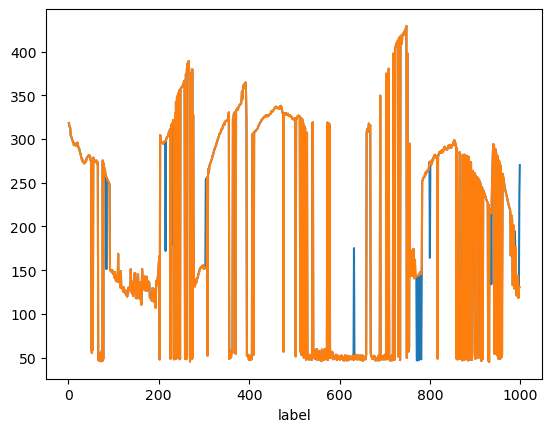

In [43]:
df_props['centroid-0'].plot()
df_props_correct['centroid-0'].plot()

## Wound

In [7]:
wound = get_holes_mask(mask)
segmentator = SingleObjectFeatures(wound,wound, params=prop)
df_props_wound = segmentator.get_features()

In [138]:
laser_frame = 0 

In [14]:
df_props_corrected,times  = clean_results(df_props,df_drift,3)

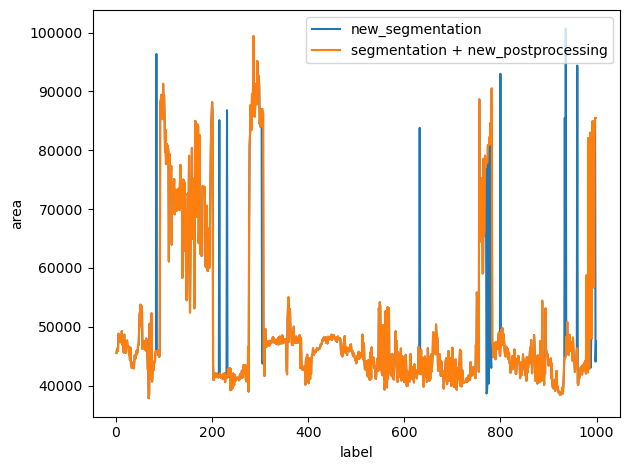

In [46]:
df_props['area'].plot()
#df_props_corrected['area'].plot()
df_props_correct['area'].plot()
plt.ylabel('area')
plt.tight_layout()
plt.legend(['new_segmentation','segmentation + new_postprocessing'])
plt.savefig('../data/results/figures/complete_pipeline/correction_v3.png',dpi=300)

<AxesSubplot:xlabel='label'>

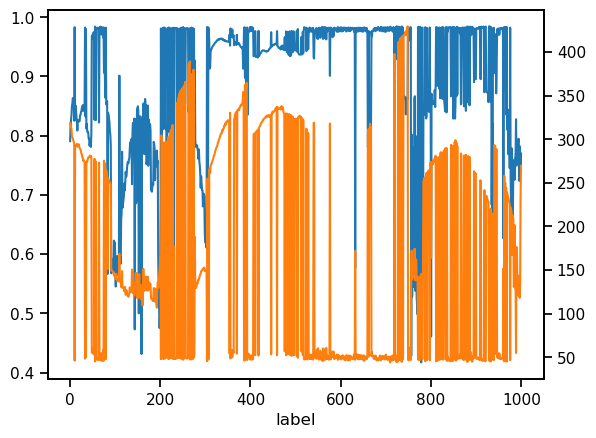

In [254]:
fig,ax = plt.subplots()
ax2 = ax.twinx()

df_props.eccentricity.plot(ax=ax)
df_props['centroid-0'].plot(ax=ax2,color='tab:orange')



In [330]:
df_props.eccentricity.std()

0.11731388790697549

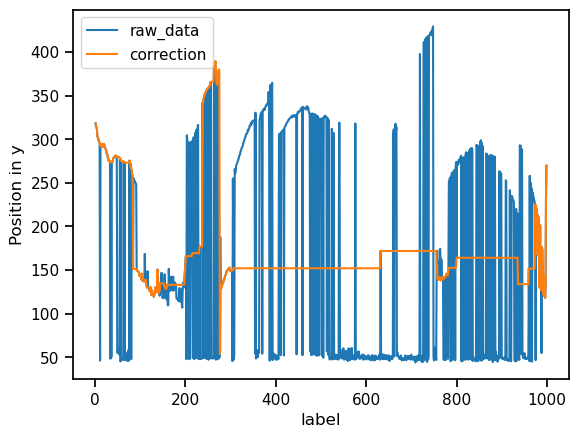

In [347]:
df_props['centroid-0'].plot()
df_props_corrected['centroid-0'].plot()
plt.ylabel('Position in y')
plt.legend(['raw_data', 'correction'])
#plt.savefig('../data/new_movies/results/correction.png',dpi=300)
plt.show()

In [50]:
df_props_wound_correct = clean_results(df_props_wound,df_drift)
df_props_wound_correct,time_wound = interpolate_wound(df_props_wound_correct,df_props_correct,laser = laser_frame)

C:\Users\nessl\miniconda3\envs\placozoa\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\nessl\miniconda3\envs\placozoa\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [11]:
end = time.time() - start
print(f'The whole pipeline took {end/60:.2f} minutes to complete')

NameError: name 'start' is not defined

# Plotting results and extracting features

In [63]:
size_pixel=2.6 #in microns

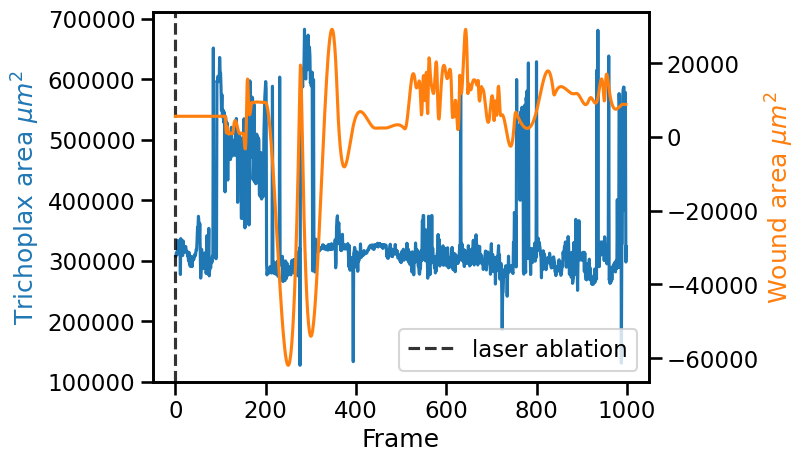

In [72]:
sns.set_context('talk')
fig,ax = plt.subplots()
ax2 = ax.twinx()

area_w = np.array((df_props_wound_correct.area.values))
area_o = np.array((df_props_correct.area.values))

sns.lineplot(x=df_props_correct.index.values,y = df_props_correct.area*(size_pixel)*(size_pixel),ax = ax,color='tab:blue')
sns.lineplot(x=df_props_wound_correct.index.values,y = df_props_wound_correct.area*(size_pixel)*(size_pixel), ax = ax2,color='tab:orange')
ax.set_ylabel('Trichoplax area $\mu m^2$',color = 'tab:blue')
ax2.set_ylabel('Wound area $\mu m^2$',color='tab:orange')
ax.set_xlabel('Frame')
ax.axvline(laser_frame,0,ax.get_ylim()[1],linestyle='--',color='black',alpha=0.8,label='laser ablation')
ax.legend()

plt.show()

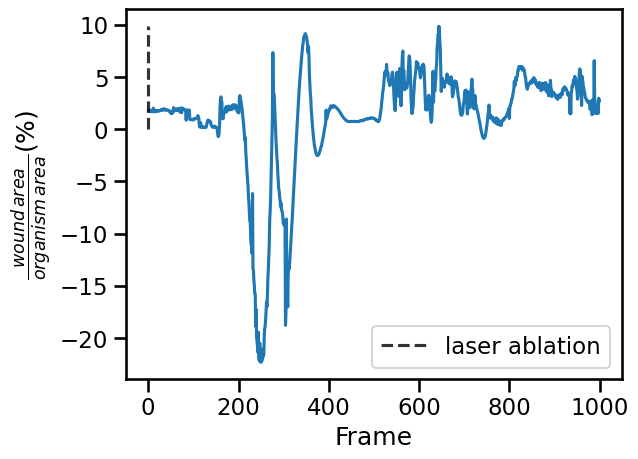

In [70]:
sns.lineplot(x = df_props.index.values,y = (area_w/area_o)*100)
plt.ylabel(r"$ \frac{wound\,area}{organism\,area}$" + '(%)')
plt.xlabel('Frame')
plt.vlines(laser_frame,0,max((area_w/area_o)*100),linestyle='--',color='black',alpha=0.8,label='laser ablation')
plt.legend()
plt.show()

<AxesSubplot:ylabel='area'>

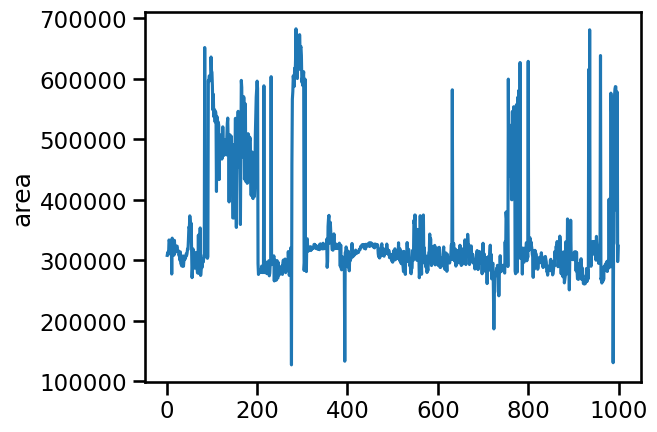

In [67]:
sns.lineplot(x=df_props_correct.index.values,y = df_props_correct.area*(size_pixel)*(size_pixel),color='tab:blue')

In [83]:
df_props_correct['centroid-0'].values[0]

318.2098448438563

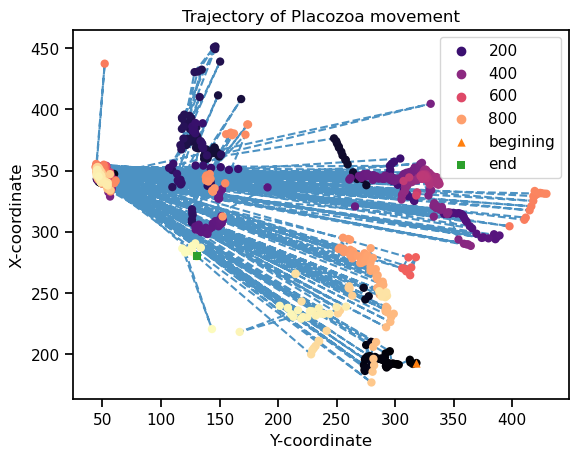

In [57]:
sns.set_context('notebook')

fig,ax = plt.subplots()

sns.scatterplot(x = df_props_correct['centroid-0'],y = df_props_correct['centroid-1'],marker="o"
                ,hue=df_props_correct.index,palette="magma",linewidth=0,ax=ax,hue_norm=(0,1000),zorder=1)

ax.scatter(x = df_props_correct['centroid-0'].values[0],y = df_props_correct['centroid-1'].values[0]
                ,marker="^",linewidth=0,label='begining',zorder=2)
ax.scatter(x = df_props_correct['centroid-0'].values[-1],y = df_props_correct['centroid-1'].values[-1]
                ,marker="s",linewidth=0,label='end',zorder=2)

ax.plot(df_props_correct['centroid-0'],df_props_correct['centroid-1'],linestyle='--',zorder=0,alpha=0.8)

plt.xlabel('Y-coordinate')
plt.ylabel('X-coordinate')
plt.title('Trajectory of Placozoa movement')
plt.legend()
plt.show()

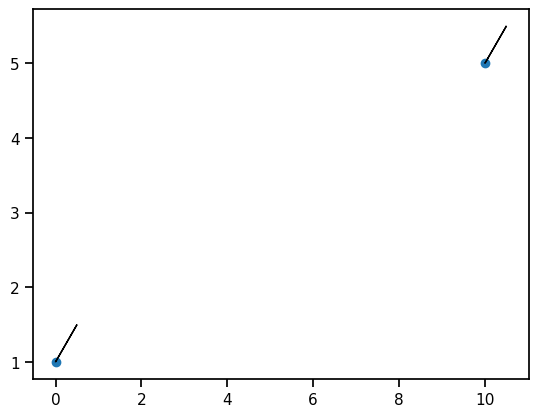

In [129]:
def getEquidistantPoints(x1, x2,y1,y2, ax,parts = 1):
    x = np.linspace(x1, x2, parts+1,dtype=int)
    y = np.linspace(y1, y2, parts+1,dtype=int)
    for i,j in enumerate(x):
        ax.arrow(j,y[i],0.5,0.5,length_includes_head=True)
        
fig,ax = plt.subplots()

ax.scatter([0,10],[1,5])
getEquidistantPoints(0,10,1,5,ax)

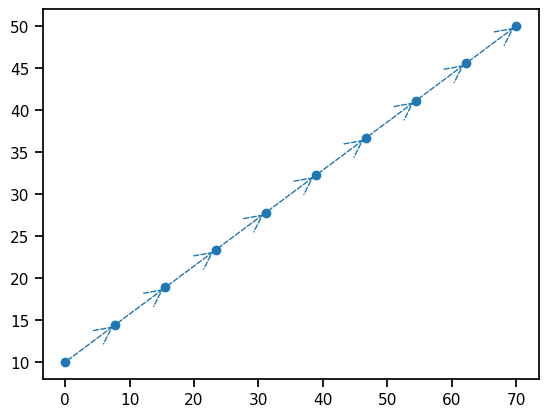

In [112]:
def getEquidistantPoints(x1, x2,y1,y2, parts = 1,ax):
    x = np.linspace(x1, x2, parts+1,dtype=int)
    y = np.linspace(y1, y2, parts+1,dtype=int)
    for i,j in enumerate(x):
        ax.arrow(j,y[i],0.1,5)
    #return 


from matplotlib.patches import FancyArrowPatch 

def arrow(x,y,ax,n):
    d = len(x)//(n+1)    
    ind = np.arange(d,len(x),d)
    for i in ind:
        ar = FancyArrowPatch ((x[i-1],y[i-1]),(x[i],y[i]),linestyle="--",
                              arrowstyle=u'->', mutation_scale=30,color='tab:blue')
        ax.add_patch(ar)
        
        
x = np.linspace(0,70,10)
y = np.linspace(10,50,10)

fig,ax = plt.subplots()
#arrow(x,y,ax,5)
ax.scatter(x,y,zorder=2)

#ax.plot(x,y,'--',zorder=1)


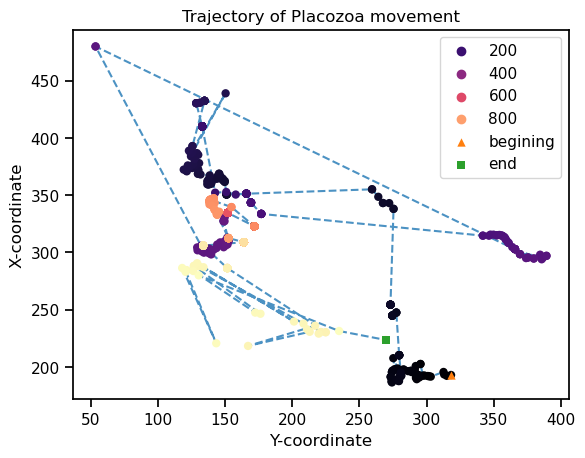

In [123]:
sns.set_context('notebook')

fig,ax = plt.subplots()
        
sns.scatterplot(x = df_props_corrected['centroid-0'],y = df_props_corrected['centroid-1'],marker="o"
                ,hue=df_props_corrected.index,palette="magma",linewidth=0,ax=ax,hue_norm=(0,1000),zorder=1)

ax.scatter(x = df_props_corrected['centroid-0'].values[0],y = df_props_corrected['centroid-1'].values[0]
                ,marker="^",linewidth=0,label='begining',zorder=2)
ax.scatter(x = df_props_corrected['centroid-0'].values[-1],y = df_props_corrected['centroid-1'].values[-1]
                ,marker="s",linewidth=0,label='end',zorder=2)

ax.plot(df_props_corrected['centroid-0'],df_props_corrected['centroid-1'],linestyle='--',zorder=0,alpha=0.8)

#arrow(df_props_corrected['centroid-0'],df_props_corrected['centroid-1'],ax,400)

plt.xlabel('Y-coordinate')
plt.ylabel('X-coordinate')
plt.title('Trajectory of Placozoa movement')
plt.legend()
plt.show()

# Saving the images and dataframes

## Saving the preprocessed image

In [ ]:
path_preprocessed = r"D:\Lab2\data_tif\results\preprocesed_19102022_16h02.tif"
imwrite(path_preprocessed,preprocessed)

## Saving the mask

In [250]:
path_mask = '../data/new_movies/results/mask/preprocesed_19102022_16h02_mask.tif'
imwrite(path_mask,mask)

## Saving the dataframes

In [ ]:
path_props= ''
path_props_wound = ''

df_props_correct.tocsv(path_props)
df_props_wound_correct.tocsv(path_props_wound)

# Optional : visualizing the drift

In [ ]:
canva,diffx,diffy = pi.create_canva(df_drift,preprocessed)

rescaled = pi.place_img(canva,diffx,diffy,preprocessed,df_drift,res)

## Saving the canva

In [ ]:
path_canva = '../data/tricho_8_wound_drift_visualization.tif'
imwrite(path_canva,rescaled,compression='zlib') #adding compression to reduce file size

In [ ]:
path_preprocessed = r"D:\Lab2\data_tif\results\preprocesed_19102022_16h02_mask_chanvese.tif"
imwrite(path_preprocessed,mask)

In [442]:
test = imread('../data/tricho_8_preprocessed_otsu.tif')#[0,...]


In [436]:
preprocessed[0,...]

array([[  0,   0,   0, ..., 108, 112, 100],
       [  0,   0,   0, ...,  91, 108, 129],
       [  0,   0,   0, ...,  87, 100, 117],
       ...,
       [200, 183, 204, ..., 234, 229, 246],
       [204, 200, 204, ..., 238, 250, 229],
       [234, 217, 225, ..., 246, 242, 238]], dtype=uint8)

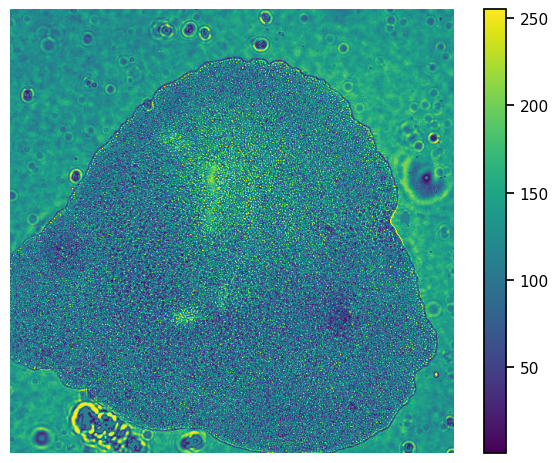

In [449]:
plt.imshow(test[0])
plt.colorbar()
plt.axis('off')
plt.savefig('../data/results/contrast.png',dpi=300)
plt.tight_layout()
plt.show()

In [49]:
mask[0]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])